#01_EDA

In [4]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib


import sklearn
import xgboost
from xgboost import XGBRegressor


from sklearn.model_selection import KFold

import random as rn

RANDOM_SEED = 2025
np.random.seed(RANDOM_SEED)
rn.seed(RANDOM_SEED)



from datetime import datetime

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [5]:
# 한글 폰트 관련
# 1. 나눔 폰트 설치
!apt-get -y install fonts-nanum

# 2. 런타임 재시작 없이 폰트 강제 등록
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl

# 3. 폰트 경로 직접 지정
font_path = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"
fm.fontManager.addfont(font_path)
nanum_font = fm.FontProperties(fname=font_path).get_name()

# 4. matplotlib 기본 설정에 강제로 반영
mpl.rcParams['font.family'] = nanum_font
mpl.rcParams['axes.unicode_minus'] = False


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


In [ ]:
%cd /content/drive/MyDrive/dacon_2025_Power_usage_prediction_AI_github/2025dacon_powerU_github

In [ ]:
!git config --global user.name "SonHyesang0914"
!git config --global user.email "hyesang0914@gmail.com"

In [ ]:
train_path = "/content/drive/MyDrive/dacon_2025_Power_usage_prediction_AI/dacon_data/train.csv"
test_path = "/content/drive/MyDrive/dacon_2025_Power_usage_prediction_AI/dacon_data/test.csv"
building_info_path = "/content/drive/MyDrive/dacon_2025_Power_usage_prediction_AI/dacon_data/building_info.csv"

In [ ]:
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)
building_info = pd.read_csv(building_info_path)

In [ ]:
#한글로 된 행 영어로 변환
train = train.rename(columns={
    '건물번호': 'building_num',
    '일시': 'date_time',
    '기온(°C)': 'temperature',
    '강수량(mm)': 'rainfall',
    '풍속(m/s)': 'windspeed',
    '습도(%)': 'humidity',
    '일조(hr)': 'sunshine',
    '일사(MJ/m2)': 'solar_radiation',
    '전력소비량(kWh)': 'power_consumption'
})
train.drop('num_date_time', axis = 1, inplace=True)

test = test.rename(columns={
    '건물번호': 'building_num',
    '일시': 'date_time',
    '기온(°C)': 'temperature',
    '강수량(mm)': 'rainfall',
    '풍속(m/s)': 'windspeed',
    '습도(%)': 'humidity',
    '일조(hr)': 'sunshine',
    '일사(MJ/m2)': 'solar_radiation',
    '전력소비량(kWh)': 'power_consumption'
})
test.drop('num_date_time', axis = 1, inplace=True)

building_info = building_info.rename(columns={
    '건물번호': 'building_num',
    '건물유형': 'building_type',
    '연면적(m2)': 'total_area',
    '냉방면적(m2)': 'cooling_area',
    '태양광용량(kW)': 'solar_power_capacity',
    'ESS저장용량(kWh)': 'ess_capacity',
    'PCS용량(kW)': 'pcs_capacity'
})

#한글로 된 건물 유형 영어로 변환
translation_dict = {
    '건물기타': 'Other_building',
    '공공': 'Public',
    '학교': 'University',
    '백화점': 'Department_store',
    '병원': 'Hospital',
    '상용': 'Commercial',
    '아파트': 'Apartment',
    '연구소': 'Laboratory',
    'IDC(전화국)': 'IDC',
    '호텔': 'Hotel'
}

building_info['building_type'] = building_info['building_type'].replace(translation_dict)

#태양광 기술이나 ess(pcs 포함)기술 유무 행 추가 있으면 1 없으면 0
#하는 이유? 단순 존재 여부 판단 편리 -> 시각화나 조건달 때 편리
#그리고 트리모델에서 더 잘 활용하기 위해 0과 1로 이분화
building_info['solar_power_include'] = np.where(building_info.solar_power_capacity !='-',1,0)
building_info['ess_include'] = np.where(building_info.ess_capacity !='-',1,0)

building_info = building_info.drop(columns=['solar_power_capacity', 'ess_capacity', 'pcs_capacity'], errors='ignore')

train = pd.merge(train, building_info, on='building_num', how='left')
test = pd.merge(test, building_info, on='building_num', how='left')

In [ ]:
train['date_time'] = pd.to_datetime(train['date_time'], format='%Y%m%d %H')

# date time feature 생성
train['hour'] = train['date_time'].dt.hour
train['day'] = train['date_time'].dt.day
train['month'] = train['date_time'].dt.month
train['day_of_week'] = train['date_time'].dt.dayofweek #요일


test['date_time'] = pd.to_datetime(test['date_time'], format='%Y%m%d %H')

# date time feature 생성
test['hour'] = test['date_time'].dt.hour
test['day'] = test['date_time'].dt.day
test['month'] = test['date_time'].dt.month
test['day_of_week'] = test['date_time'].dt.dayofweek #요일

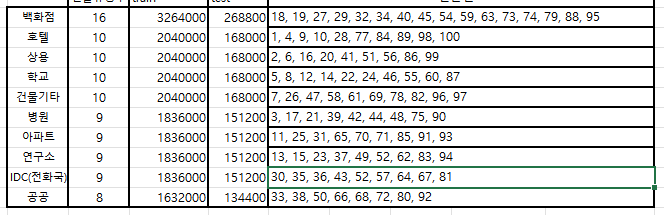


In [ ]:
from datetime import timedelta

# 시작 날짜와 종료 날짜
start = train['date_time'].min().date()
end = train['date_time'].max().date()

b_id = 76

temp = train[train['building_num'] == b_id].copy()
temp = temp.sort_values('date_time')

# 주간 단위 반복
current = start
while current + timedelta(days=7) <= end:
    s = pd.to_datetime(current)
    e = pd.to_datetime(current + timedelta(days=7))

    week_temp = temp[(temp['date_time'] >= s) & (temp['date_time'] < e)]

    plt.figure(figsize=(15, 4))
    sns.lineplot(data=week_temp, x='date_time', y='power_consumption', linewidth=0.7)
    plt.title(f"건물 {b_id} | {s.date()} ~ {(e - timedelta(days=1)).date()} 시간단위 전력사용량")
    plt.xlabel("시간")
    plt.ylabel("전력사용량 (kWh)")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    current += timedelta(days=7)


In [ ]:
b_id = 100

temp = train[train['building_num'] == b_id].copy()

plt.figure(figsize=(20, 4))
sns.lineplot(data=temp, x='date_time', y='power_consumption', linewidth=0.5)
plt.title(f"건물 {b_id} 전체 기간 전력사용량")
plt.xlabel("시간")
plt.ylabel("전력사용량 (kWh)")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
def overwrite_day_by_md(df, building, target_month, target_day, source_month, source_day,
                        col='power_consumption', keep_backup=True, log_list=None):
    """
    month/day 컬럼 기반으로 하루 단위 덮어쓰기
    building: 건물 번호(int)
    target_month, target_day: 덮어쓸 대상 월/일 (int)
    source_month, source_day: 덮어올 소스 월/일 (int)
    col: 덮을 컬럼명
    keep_backup: 원본 보관 여부
    log_list: 변경 이력 저장 리스트
    """
    m_src = (df['building_num']==building) & (df['month']==source_month) & (df['day']==source_day)
    m_tgt = (df['building_num']==building) & (df['month']==target_month) & (df['day']==target_day)

    n_src, n_tgt = m_src.sum(), m_tgt.sum()
    if n_src == 0 or n_tgt == 0:
        print(f"[WARN] 소스({n_src}), 타겟({n_tgt}) 행 없음")
        return df

    # 시간별 소스 값 준비
    src_hour_map = df.loc[m_src, ['hour', col]].set_index('hour')[col]

    # 덮어쓰기
    tgt_hours = df.loc[m_tgt, 'hour']
    new_vals = tgt_hours.map(src_hour_map)
    df.loc[m_tgt, col] = new_vals.fillna(df.loc[m_tgt, col]).values

    # 로그
    if log_list is not None:
        log_list.append({
            'building': building,
            'target_md': f"{target_month:02d}-{target_day:02d}",
            'source_md': f"{source_month:02d}-{source_day:02d}",
            'rows_changed': int(n_tgt),
            'column': col
        })
    return df


In [ ]:
def plot_building_day(df, building_id, date, col='power_consumption'):
    """
    특정 건물 + 하루의 시간별 전력 사용량을 시각화
    df: 데이터프레임 (필수: building_num, date_time, col)
    building_id: int, 건물 번호
    date: 'YYYY-MM-DD' 형식 문자열 또는 datetime.date
    col: 전력 사용량 컬럼명 (기본 'power_consumption')
    """
    d = pd.to_datetime(date).date()

    temp = df[(df['building_num']==building_id) &
              (df['date_time'].dt.date == d)].copy()

    if temp.empty:
        print(f"[INFO] 해당 날짜에 데이터가 없습니다. 건물={building_id}, {d}")
        return

    temp = temp.sort_values('date_time')

    plt.figure(figsize=(12,4))
    sns.lineplot(data=temp, x='date_time', y=col, linewidth=1)
    plt.title(f"건물 {building_id} | {d} 하루 전력사용량")
    plt.xlabel("시간")
    plt.ylabel("전력사용량 (kWh)")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [ ]:
def plot_building_power(df, building_id, start_date, end_date, col='power_consumption'):
    """
    특정 건물 + 날짜 범위의 시간별 전력 사용량을 시각화
    df: 데이터프레임 (필수 컬럼: building_num, date_time, col)
    building_id: int, 건물 번호
    start_date, end_date: 'YYYY-MM-DD' 형식 문자열 또는 datetime/date
    col: 전력 사용량 컬럼명 (기본 'power_consumption')
    """
    # 날짜 처리
    s = pd.to_datetime(start_date)
    e = pd.to_datetime(end_date)

    temp = df[(df['building_num']==building_id) &
              (df['date_time'] >= s) & (df['date_time'] <= e)].copy()

    if temp.empty:
        print(f"[INFO] 해당 구간에 데이터가 없습니다. 건물={building_id}, {s.date()}~{e.date()}")
        return

    temp = temp.sort_values('date_time')

    plt.figure(figsize=(15,4))
    sns.lineplot(data=temp, x='date_time', y=col, linewidth=0.7)
    plt.title(f"건물 {building_id} | {s.date()} ~ {e.date()} 시간단위 전력사용량")
    plt.xlabel("시간")
    plt.ylabel("전력사용량 (kWh)")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [ ]:




def overwrite_by_ref_avg(df, building, month, day, target_hours, ref_hour1, ref_hour2,
                         col='power_consumption', keep_backup=True, log_list=None):
    """
    df: 시계열 데이터프레임 (필수 컬럼: building_num, month, day, hour, col)
    building: int, 건물번호
    month, day: int, 대상 날짜
    target_hours: int 또는 iterable(int), 바꿀 'hour' (예: 9 or [9,10,11])
    ref_hour1, ref_hour2: int, 기준 시간 2개 (같은 날짜에서 가져옴)
    col: 수정할 컬럼명 (기본 'power_consumption')
    log_list: 변경 이력 저장용 리스트(선택)
    """

    # hours 입력 정규화
    if isinstance(target_hours, (int, np.integer)):
        target_hours = [int(target_hours)]
    else:
        target_hours = list(target_hours)

    # 대상/기준 마스크
    m_day = (df['building_num']==building) & (df['month']==month) & (df['day']==day)

    # 기준값 확보
    m_ref1 = m_day & (df['hour']==int(ref_hour1))
    m_ref2 = m_day & (df['hour']==int(ref_hour2))

    if m_ref1.sum()==0 or m_ref2.sum()==0:
        print(f"[WARN] 기준시간 존재 안함 -> ref1({m_ref1.sum()}), ref2({m_ref2.sum()}) "
              f"[b={building}, {month:02d}-{day:02d}, ref={ref_hour1},{ref_hour2}]")
        return df

    ref_val1 = df.loc[m_ref1, col].iloc[0]
    ref_val2 = df.loc[m_ref2, col].iloc[0]

    if pd.isna(ref_val1) or pd.isna(ref_val2):
        print(f"[WARN] 기준시간 값이 NaN입니다. ref1={ref_val1}, ref2={ref_val2}")
        return df

    new_val = (float(ref_val1) + float(ref_val2)) / 2.0

    # 타깃 치환
    m_tgt = m_day & (df['hour'].isin(target_hours))
    changed_rows = int(m_tgt.sum())
    if changed_rows == 0:
        print(f"[INFO] 바꿀 시간대 행이 없습니다. [b={building}, {month:02d}-{day:02d}, hours={target_hours}]")
        return df

    df.loc[m_tgt, col] = new_val

    # 로그
    if log_list is not None:
        log_list.append({
            'building': int(building),
            'month': int(month),
            'day': int(day),
            'target_hours': list(map(int, target_hours)),
            'ref_hour1': int(ref_hour1),
            'ref_hour2': int(ref_hour2),
            'new_val': float(new_val),
            'rows_changed': changed_rows,
            'column': col
        })

    return df


In [ ]:
def reduce_daytime_range(df, building, month, day, start_hour, end_hour,
                         reduce_val, col='power_consumption',
                         keep_backup=True, log_list=None):
    """
    특정 건물, 특정 날짜 하루에서 start_hour~end_hour 범위의 값에 일정 값을 빼줌
    df: DataFrame (필수 컬럼: building_num, month, day, hour, col)
    building: int, 건물번호
    month, day: int, 대상 날짜
    start_hour, end_hour: 시간 범위 (포함 조건, int)
    reduce_val: 빼줄 값
    col: 수정할 컬럼명
    log_list: 변경 이력 기록용 리스트
    """
    # 대상 마스크
    m = ((df['building_num']==building) &
         (df['month']==month) & (df['day']==day) &
         (df['hour']>=start_hour) & (df['hour']<=end_hour))

    df.loc[m, col] = df.loc[m, col] - reduce_val
    df.loc[m, col] = df.loc[m, col].clip(lower=0)  # 음수 방지

    if log_list is not None:
        log_list.append({
            'building': building,
            'month': month,
            'day': day,
            'start_hour': start_hour,
            'end_hour': end_hour,
            'reduce_val': reduce_val,
            'rows_changed': int(m.sum()),
            'column': col
        })
    return df


In [ ]:
def increase_daytime_range(df, building, month, day, start_hour, end_hour,
                         increase_val, col='power_consumption',
                         keep_backup=True, log_list=None):
    """
    특정 건물, 특정 날짜 하루에서 start_hour~end_hour 범위의 값에 일정 값을 더해줌
    df: DataFrame (필수 컬럼: building_num, month, day, hour, col)
    building: int, 건물번호
    month, day: int, 대상 날짜
    start_hour, end_hour: 시간 범위 (포함 조건, int)
    increase_val: 더해줄 값
    col: 수정할 컬럼명
    log_list: 변경 이력 기록용 리스트
    """
    # 대상 마스크
    m = ((df['building_num']==building) &
         (df['month']==month) & (df['day']==day) &
         (df['hour']>=start_hour) & (df['hour']<=end_hour))

    df.loc[m, col] = df.loc[m, col] + increase_val
    df.loc[m, col] = df.loc[m, col].clip(lower=0)  # 음수 방지

    if log_list is not None:
        log_list.append({
            'building': building,
            'month': month,
            'day': day,
            'start_hour': start_hour,
            'end_hour': end_hour,
            'increase_val': increase_val,
            'rows_changed': int(m.sum()),
            'column': col
        })
    return df


In [ ]:
plot_building_power(train, building_id=19, start_date="2024-07-24", end_date="2024-07-31")


#02_EDAandPreprocessing

## 02-1. 이상값 처리

In [ ]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=18, month=6, day=11,
    target_hours=17,
    ref_hour1=16, ref_hour2=19,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


In [ ]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=18, month=6, day=11,
    target_hours=18,
    ref_hour1=17, ref_hour2=19,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


In [ ]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=18, month=7, day=17,
    target_hours=14,
    ref_hour1=13, ref_hour2=15,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


In [ ]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=18, month=8, day=8,
    target_hours=15,
    ref_hour1=14, ref_hour2=17,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


In [ ]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=18, month=8, day=8,
    target_hours=15,
    ref_hour1=14, ref_hour2=17,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


In [ ]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=18, month=8, day=8,
    target_hours=16,
    ref_hour1=15, ref_hour2=17,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


In [ ]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=19, month=7, day=31,
    target_hours=13,
    ref_hour1=12, ref_hour2=17,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


In [ ]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=19, month=7, day=31,
    target_hours=14,
    ref_hour1=13, ref_hour2=17,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


In [ ]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=19, month=7, day=31,
    target_hours=range(15, 17),
    ref_hour1=13, ref_hour2=18,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


In [ ]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=29, month=6, day=15,
    target_hours=22,
    ref_hour1=8, ref_hour2=9,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


In [ ]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=29, month=6, day=15,
    target_hours=23,
    ref_hour1=7, ref_hour2=22,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


In [ ]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=29, month=6, day=16,
    target_hours=0,
    ref_hour1=5, ref_hour2=6,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


In [ ]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=29, month=6, day=27,
    target_hours=0,
    ref_hour1=6, ref_hour2=7,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


In [ ]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=29, month=6, day=27,
    target_hours=1,
    ref_hour1=0, ref_hour2=2,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


In [ ]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=40, month=7, day=14,
    target_hours=0,
    ref_hour1=1, ref_hour2=7,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


In [ ]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=40, month=7, day=14,
    target_hours=1,
    ref_hour1=1, ref_hour2=2,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


In [ ]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=73, month=7, day=8,
    target_hours=22,
    ref_hour1=21, ref_hour2=23,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


In [ ]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=79, month=8, day=19,
    target_hours=3,
    ref_hour1=1, ref_hour2=2,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


In [ ]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=79, month=8, day=19,
    target_hours=4,
    ref_hour1=2, ref_hour2=3,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


In [ ]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=79, month=8, day=19,
    target_hours=5,
    ref_hour1=0, ref_hour2=3,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


In [ ]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=88, month=8, day=23,
    target_hours=8,
    ref_hour1=7, ref_hour2=9,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


In [ ]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=88, month=8, day=23,
    target_hours=7,
    ref_hour1=7, ref_hour2=8,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


In [ ]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=95, month=8, day=5,
    target_hours=10,
    ref_hour1=9, ref_hour2=12,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


In [ ]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=95, month=8, day=5,
    target_hours=11,
    ref_hour1=10, ref_hour2=12,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


In [ ]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=9, month=6, day=12,
    target_hours=10,
    ref_hour1=10, ref_hour2=12,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


In [ ]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=9, month=6, day=12,
    target_hours=11,
    ref_hour1=11, ref_hour2=12,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


In [ ]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=77, month=7, day=17,
    target_hours=14,
    ref_hour1=12, ref_hour2=16,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


In [ ]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=77, month=7, day=17,
    target_hours=15,
    ref_hour1=14, ref_hour2=16,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


In [ ]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=77, month=8, day=6,
    target_hours=17,
    ref_hour1=7, ref_hour2=17,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


In [ ]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=77, month=8, day=6,
    target_hours=18,
    ref_hour1=18, ref_hour2=19,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


In [ ]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=77, month=8, day=20,
    target_hours=10,
    ref_hour1=10, ref_hour2=11,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


In [ ]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=77, month=8, day=20,
    target_hours=9,
    ref_hour1=10, ref_hour2=11,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


In [ ]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=77, month=8, day=21,
    target_hours=19,
    ref_hour1=21, ref_hour2=20,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


In [ ]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=77, month=8, day=21,
    target_hours=18,
    ref_hour1=19, ref_hour2=21,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


In [ ]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=77, month=8, day=21,
    target_hours=17,
    ref_hour1=16, ref_hour2=18,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


In [ ]:
edit_log = []
train = overwrite_day_by_md(train, building=89,
                            target_month=7, target_day=11,
                            source_month=7, source_day=7,
                            col='power_consumption',
                            keep_backup=True,
                            log_list=edit_log)

print(edit_log[-1])  # 마지막 변경 이력 확인

In [ ]:
edit_log = []
train = overwrite_day_by_md(train, building=89,
                            target_month=7, target_day=12,
                            source_month=7, source_day=18,
                            col='power_consumption',
                            keep_backup=True,
                            log_list=edit_log)

print(edit_log[-1])  # 마지막 변경 이력 확인

In [ ]:
edit_log = []
train = overwrite_day_by_md(train, building=89,
                            target_month=7, target_day=15,
                            source_month=7, source_day=8,
                            col='power_consumption',
                            keep_backup=True,
                            log_list=edit_log)

print(edit_log[-1])  # 마지막 변경 이력 확인

In [ ]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=89, month=8, day=20,
    target_hours=22,
    ref_hour1=14, ref_hour2=11,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


In [ ]:
edit_log = []
train = overwrite_day_by_md(train, building=98,
                            target_month=6, target_day=6,
                            source_month=6, source_day=2,
                            col='power_consumption',
                            keep_backup=True,
                            log_list=edit_log)

print(edit_log[-1])  # 마지막 변경 이력 확인

In [ ]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=98, month=6, day=13,
    target_hours=14,
    ref_hour1=11, ref_hour2=12,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


In [ ]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=98, month=6, day=13,
    target_hours=15,
    ref_hour1=11, ref_hour2=16,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


In [ ]:
edit_log = []

train = reduce_daytime_range(train, building=100, month=7, day=10,
                             start_hour=3, end_hour=21,
                             reduce_val=400,
                             col='power_consumption',
                             keep_backup=True,
                             log_list=edit_log)

print(edit_log[-1])  # 마지막 변경 로그 확인


In [ ]:
edit_log = []

train = reduce_daytime_range(train, building=100, month=7, day=11,
                             start_hour=3, end_hour=21,
                             reduce_val=400,
                             col='power_consumption',
                             keep_backup=True,
                             log_list=edit_log)

print(edit_log[-1])  # 마지막 변경 로그 확인


In [ ]:
edit_log = []

train = reduce_daytime_range(train, building=100, month=7, day=12,
                             start_hour=3, end_hour=21,
                             reduce_val=400,
                             col='power_consumption',
                             keep_backup=True,
                             log_list=edit_log)

print(edit_log[-1])  # 마지막 변경 로그 확인


In [ ]:
edit_log = []

train = reduce_daytime_range(train, building=100, month=7, day=13,
                             start_hour=3, end_hour=18,
                             reduce_val=400,
                             col='power_consumption',
                             keep_backup=True,
                             log_list=edit_log)

print(edit_log[-1])  # 마지막 변경 로그 확인


In [ ]:
edit_log = []

train = reduce_daytime_range(train, building=100, month=7, day=14,
                             start_hour=8, end_hour=20,
                             reduce_val=500,
                             col='power_consumption',
                             keep_backup=True,
                             log_list=edit_log)

print(edit_log[-1])  # 마지막 변경 로그 확인


In [ ]:
edit_log = []
train = overwrite_day_by_md(train, building=100,
                            target_month=8, target_day=9,
                            source_month=8, source_day=6,
                            col='power_consumption',
                            keep_backup=True,
                            log_list=edit_log)

print(edit_log[-1])  # 마지막 변경 이력 확인

In [ ]:
edit_log = []
train = overwrite_day_by_md(train, building=100,
                            target_month=8, target_day=10,
                            source_month=8, source_day=7,
                            col='power_consumption',
                            keep_backup=True,
                            log_list=edit_log)

print(edit_log[-1])  # 마지막 변경 이력 확인

In [ ]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=18, month=7, day=17,
    target_hours=range(13, 15),
    ref_hour1=9, ref_hour2=15,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


In [ ]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=20, month=6, day=1,
    target_hours=10,
    ref_hour1=9, ref_hour2=12,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


In [ ]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=20, month=6, day=1,
    target_hours=11,
    ref_hour1=10, ref_hour2=12,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


In [ ]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=41, month=6, day=22,
    target_hours=1,
    ref_hour1=0, ref_hour2=5,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


In [ ]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=41, month=6, day=22,
    target_hours=2,
    ref_hour1=0, ref_hour2=6,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


In [ ]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=41, month=6, day=22,
    target_hours=3,
    ref_hour1=0, ref_hour2=7,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


In [ ]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=41, month=6, day=22,
    target_hours=4,
    ref_hour1=0, ref_hour2=8,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


In [ ]:
edit_log = []
train = overwrite_day_by_md(train, building=41,
                            target_month=7, target_day=17,
                            source_month=7, source_day=14,
                            col='power_consumption',
                            keep_backup=True,
                            log_list=edit_log)

print(edit_log[-1])  # 마지막 변경 이력 확인

In [ ]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=51, month=6, day=10,
    target_hours=17,
    ref_hour1=16, ref_hour2=18,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


In [ ]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=51, month=6, day=24,
    target_hours=17,
    ref_hour1=16, ref_hour2=18,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


In [ ]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=51, month=7, day=15,
    target_hours=17,
    ref_hour1=16, ref_hour2=18,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


In [ ]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=51, month=7, day=29,
    target_hours=17,
    ref_hour1=16, ref_hour2=18,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


In [ ]:
edit_log = []

train = reduce_daytime_range(train, building=99, month=7, day=3,
                             start_hour=5, end_hour=7,
                             reduce_val=300,
                             col='power_consumption',
                             keep_backup=True,
                             log_list=edit_log)

print(edit_log[-1])  # 마지막 변경 로그 확인


In [ ]:
edit_log = []

train = increase_daytime_range(train, building=99, month=7, day=10,
                             start_hour=5, end_hour=7,
                             increase_val=150,
                             col='power_consumption',
                             keep_backup=True,
                             log_list=edit_log)

print(edit_log[-1])  # 마지막 변경 로그 확인


In [ ]:
edit_log = []

train = reduce_daytime_range(train, building=99, month=8, day=7,
                             start_hour=5, end_hour=7,
                             reduce_val=400,
                             col='power_consumption',
                             keep_backup=True,
                             log_list=edit_log)

print(edit_log[-1])  # 마지막 변경 로그 확인


In [ ]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=5, month=8, day=4,
    target_hours=7,
    ref_hour1=6, ref_hour2=9,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


In [ ]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=5, month=8, day=4,
    target_hours=8,
    ref_hour1=7, ref_hour2=9,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


In [ ]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=8, month=7, day=21,
    target_hours=8,
    ref_hour1=8, ref_hour2=14,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


In [ ]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=8, month=7, day=21,
    target_hours=9,
    ref_hour1=8, ref_hour2=14,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


In [ ]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=8, month=7, day=21,
    target_hours=10,
    ref_hour1=8, ref_hour2=15,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


In [ ]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=8, month=7, day=21,
    target_hours=11,
    ref_hour1=10, ref_hour2=15,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


In [ ]:
edit_log = []
train = overwrite_day_by_md(train, building=8,
                            target_month=8, target_day=24,
                            source_month=8, source_day=10,
                            col='power_consumption',
                            keep_backup=True,
                            log_list=edit_log)

print(edit_log[-1])  # 마지막 변경 이력 확인

In [ ]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=12, month=7, day=17,
    target_hours=14,
    ref_hour1=13, ref_hour2=15,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


In [ ]:
edit_log = []

train = increase_daytime_range(train, building=12, month=7, day=21,
                             start_hour=8, end_hour=11,
                             increase_val=1500,
                             col='power_consumption',
                             keep_backup=True,
                             log_list=edit_log)

print(edit_log[-1])  # 마지막 변경 로그 확인


In [ ]:
edit_log = []

train = increase_daytime_range(train, building=12, month=7, day=21,
                             start_hour=9, end_hour=11,
                             increase_val=400,
                             col='power_consumption',
                             keep_backup=True,
                             log_list=edit_log)

print(edit_log[-1])  # 마지막 변경 로그 확인


In [ ]:
edit_log = []
train = overwrite_day_by_md(train, building=12,
                            target_month=8, target_day=24,
                            source_month=8, source_day=17,
                            col='power_consumption',
                            keep_backup=True,
                            log_list=edit_log)

print(edit_log[-1])  # 마지막 변경 이력 확인

In [ ]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=24, month=7, day=17,
    target_hours=14,
    ref_hour1=13, ref_hour2=15,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


In [ ]:
edit_log = []
train = overwrite_day_by_md(train, building=24,
                            target_month=7, target_day=20,
                            source_month=7, source_day=13,
                            col='power_consumption',
                            keep_backup=True,
                            log_list=edit_log)

print(edit_log[-1])  # 마지막 변경 이력 확인

In [ ]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=46, month=7, day=17,
    target_hours=14,
    ref_hour1=13, ref_hour2=15,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


In [ ]:
edit_log = []
train = overwrite_day_by_md(train, building=46,
                            target_month=8, target_day=17,
                            source_month=8, source_day=10,
                            col='power_consumption',
                            keep_backup=True,
                            log_list=edit_log)

print(edit_log[-1])  # 마지막 변경 이력 확인

In [ ]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=55, month=7, day=17,
    target_hours=14,
    ref_hour1=13, ref_hour2=15,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


In [ ]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=60, month=7, day=17,
    target_hours=13,
    ref_hour1=12, ref_hour2=16,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


In [ ]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=60, month=7, day=17,
    target_hours=14,
    ref_hour1=13, ref_hour2=16,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


In [ ]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=60, month=7, day=17,
    target_hours=15,
    ref_hour1=14, ref_hour2=16,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


In [ ]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=47, month=7, day=17,
    target_hours=14,
    ref_hour1=13, ref_hour2=15,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


In [ ]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=69, month=7, day=17,
    target_hours=14,
    ref_hour1=13, ref_hour2=16,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


In [ ]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=69, month=7, day=17,
    target_hours=15,
    ref_hour1=14, ref_hour2=16,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


In [ ]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=78, month=7, day=17,
    target_hours=14,
    ref_hour1=13, ref_hour2=16,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


In [ ]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=82, month=7, day=17,
    target_hours=14,
    ref_hour1=13, ref_hour2=16,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


In [ ]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=97, month=7, day=17,
    target_hours=14,
    ref_hour1=13, ref_hour2=16,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


In [ ]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=3, month=7, day=17,
    target_hours=14,
    ref_hour1=13, ref_hour2=16,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


In [ ]:
edit_log = []
train = overwrite_day_by_md(train, building=17,
                            target_month=6, target_day=25,
                            source_month=6, source_day=18,
                            col='power_consumption',
                            keep_backup=True,
                            log_list=edit_log)

print(edit_log[-1])  # 마지막 변경 이력 확인

In [ ]:
edit_log = []
train = overwrite_day_by_md(train, building=17,
                            target_month=6, target_day=26,
                            source_month=6, source_day=19,
                            col='power_consumption',
                            keep_backup=True,
                            log_list=edit_log)

print(edit_log[-1])  # 마지막 변경 이력 확인

In [ ]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=42, month=7, day=17,
    target_hours=14,
    ref_hour1=13, ref_hour2=16,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


In [ ]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=44, month=6, day=6,
    target_hours=13,
    ref_hour1=12, ref_hour2=15,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


In [ ]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=44, month=6, day=6,
    target_hours=14,
    ref_hour1=13, ref_hour2=15,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


In [ ]:
edit_log = []
train = overwrite_day_by_md(train, building=44,
                            target_month=6, target_day=29,
                            source_month=6, source_day=22,
                            col='power_consumption',
                            keep_backup=True,
                            log_list=edit_log)

print(edit_log[-1])  # 마지막 변경 이력 확인

In [ ]:
edit_log = []
train = overwrite_day_by_md(train, building=44,
                            target_month=6, target_day=30,
                            source_month=6, source_day=23,
                            col='power_consumption',
                            keep_backup=True,
                            log_list=edit_log)

print(edit_log[-1])  # 마지막 변경 이력 확인

In [ ]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=90, month=6, day=5,
    target_hours=17,
    ref_hour1=16, ref_hour2=19,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


In [ ]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=90, month=6, day=5,
    target_hours=18,
    ref_hour1=17, ref_hour2=19,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


In [ ]:
edit_log = []
train = overwrite_day_by_md(train, building=25,
                            target_month=7, target_day=4,
                            source_month=6, source_day=27,
                            col='power_consumption',
                            keep_backup=True,
                            log_list=edit_log)

print(edit_log[-1])  # 마지막 변경 이력 확인

In [ ]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=31, month=7, day=17,
    target_hours=14,
    ref_hour1=13, ref_hour2=15,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


In [ ]:
edit_log = []
train = overwrite_day_by_md(train, building=70,
                            target_month=6, target_day=4,
                            source_month=6, source_day=11,
                            col='power_consumption',
                            keep_backup=True,
                            log_list=edit_log)

print(edit_log[-1])  # 마지막 변경 이력 확인

In [ ]:
edit_log = []
train = overwrite_day_by_md(train, building=70,
                            target_month=6, target_day=5,
                            source_month=6, source_day=12,
                            col='power_consumption',
                            keep_backup=True,
                            log_list=edit_log)

print(edit_log[-1])  # 마지막 변경 이력 확인

In [ ]:
edit_log = []
train = overwrite_day_by_md(train, building=94,
                            target_month=7, target_day=27,
                            source_month=7, source_day=20,
                            col='power_consumption',
                            keep_backup=True,
                            log_list=edit_log)

print(edit_log[-1])  # 마지막 변경 이력 확인

In [ ]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=30, month=7, day=13,
    target_hours=20,
    ref_hour1=19, ref_hour2=21,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


In [ ]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=30, month=7, day=25,
    target_hours=0,
    ref_hour1=1, ref_hour2=2,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


In [ ]:
edit_log = []
train = overwrite_day_by_md(train, building=43,
                            target_month=6, target_day=10,
                            source_month=6, source_day=3,
                            col='power_consumption',
                            keep_backup=True,
                            log_list=edit_log)

print(edit_log[-1])  # 마지막 변경 이력 확인

In [ ]:
edit_log = []
train = overwrite_day_by_md(train, building=43,
                            target_month=8, target_day=12,
                            source_month=8, source_day=5,
                            col='power_consumption',
                            keep_backup=True,
                            log_list=edit_log)

print(edit_log[-1])  # 마지막 변경 이력 확인

In [ ]:
edit_log = []
train = overwrite_day_by_md(train, building=52,
                            target_month=8, target_day=10,
                            source_month=8, source_day=3,
                            col='power_consumption',
                            keep_backup=True,
                            log_list=edit_log)

print(edit_log[-1])  # 마지막 변경 이력 확인

In [ ]:
edit_log = []
train = overwrite_day_by_md(train, building=67,
                            target_month=6, target_day=10,
                            source_month=6, source_day=3,
                            col='power_consumption',
                            keep_backup=True,
                            log_list=edit_log)

print(edit_log[-1])  # 마지막 변경 이력 확인

In [ ]:
edit_log = []
train = overwrite_day_by_md(train, building=67,
                            target_month=8, target_day=12,
                            source_month=8, source_day=5,
                            col='power_consumption',
                            keep_backup=True,
                            log_list=edit_log)

print(edit_log[-1])  # 마지막 변경 이력 확인

In [ ]:
edit_log = []
train = overwrite_day_by_md(train, building=67,
                            target_month=7, target_day=26,
                            source_month=7, source_day=19,
                            col='power_consumption',
                            keep_backup=True,
                            log_list=edit_log)

print(edit_log[-1])  # 마지막 변경 이력 확인

In [ ]:
edit_log = []
train = overwrite_day_by_md(train, building=67,
                            target_month=7, target_day=27,
                            source_month=7, source_day=20,
                            col='power_consumption',
                            keep_backup=True,
                            log_list=edit_log)

print(edit_log[-1])  # 마지막 변경 이력 확인

In [ ]:
train = train[~((train['building_num'] == 57) & (train['date_time'] < "2024-06-07"))]


In [ ]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=81, month=7, day=17,
    target_hours=14,
    ref_hour1=13, ref_hour2=15,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


In [ ]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=38, month=7, day=17,
    target_hours=14,
    ref_hour1=13, ref_hour2=16,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


In [ ]:
edit_log = []

train = overwrite_by_ref_avg(
    train, building=38, month=7, day=17,
    target_hours=15,
    ref_hour1=14, ref_hour2=16,
    col='power_consumption',
    keep_backup=True,
    log_list=edit_log
)

print(edit_log[-1])  # 마지막 변경 이력 확인


In [ ]:
edit_log = []
train = overwrite_day_by_md(train, building=68,
                            target_month=6, target_day=28,
                            source_month=6, source_day=21,
                            col='power_consumption',
                            keep_backup=True,
                            log_list=edit_log)

print(edit_log[-1])  # 마지막 변경 이력 확인

In [ ]:
edit_log = []
train = overwrite_day_by_md(train, building=68,
                            target_month=6, target_day=29,
                            source_month=6, source_day=22,
                            col='power_consumption',
                            keep_backup=True,
                            log_list=edit_log)

print(edit_log[-1])  # 마지막 변경 이력 확인

In [ ]:
edit_log = []
train = overwrite_day_by_md(train, building=72,
                            target_month=7, target_day=21,
                            source_month=7, source_day=14,
                            col='power_consumption',
                            keep_backup=True,
                            log_list=edit_log)

print(edit_log[-1])  # 마지막 변경 이력 확인

In [ ]:
edit_log = []
train = overwrite_day_by_md(train, building=80,
                            target_month=7, target_day=6,
                            source_month=6, source_day=29,
                            col='power_consumption',
                            keep_backup=True,
                            log_list=edit_log)

print(edit_log[-1])  # 마지막 변경 이력 확인

In [ ]:
edit_log = []
train = overwrite_day_by_md(train, building=80,
                            target_month=7, target_day=8,
                            source_month=7, source_day=1,
                            col='power_consumption',
                            keep_backup=True,
                            log_list=edit_log)

print(edit_log[-1])  # 마지막 변경 이력 확인

In [ ]:
edit_log = []
train = overwrite_day_by_md(train, building=80,
                            target_month=7, target_day=20,
                            source_month=7, source_day=13,
                            col='power_consumption',
                            keep_backup=True,
                            log_list=edit_log)

print(edit_log[-1])  # 마지막 변경 이력 확인

In [ ]:
edit_log = []
train = overwrite_day_by_md(train, building=92,
                            target_month=7, target_day=17,
                            source_month=7, source_day=10,
                            col='power_consumption',
                            keep_backup=True,
                            log_list=edit_log)

print(edit_log[-1])  # 마지막 변경 이력 확인

In [ ]:
edit_log = []
train = overwrite_day_by_md(train, building=53,
                            target_month=6, target_day=15,
                            source_month=6, source_day=16,
                            col='power_consumption',
                            keep_backup=True,
                            log_list=edit_log)

print(edit_log[-1])  # 마지막 변경 이력 확인

In [ ]:
edit_log = []
train = overwrite_day_by_md(train, building=76,
                            target_month=6, target_day=3,
                            source_month=6, source_day=4,
                            col='power_consumption',
                            keep_backup=True,
                            log_list=edit_log)

print(edit_log[-1])  # 마지막 변경 이력 확인

In [ ]:
edit_log = []
train = overwrite_day_by_md(train, building=76,
                            target_month=6, target_day=20,
                            source_month=6, source_day=13,
                            col='power_consumption',
                            keep_backup=True,
                            log_list=edit_log)

print(edit_log[-1])  # 마지막 변경 이력 확인

In [ ]:
outlier_idx = train.index[train['power_consumption'] == 0].tolist()
print("제거할 행 개수:", len(outlier_idx))
print("인덱스 예시:", outlier_idx[:10])

# 2) 해당 인덱스들 드롭
train.drop(index=outlier_idx, inplace=True)

# 3) 드롭 후 확인
print("남은 행 개수:", train.shape[0])

## 02-2. 냉방도일, 불쾌지수, 체감온도 및 풍냉지수 추가

In [ ]:

# --- CDH ---
def add_cdh(df, base=26, window=24, out_col='CDH'):

    df = df.copy()
    df = df.sort_values(['building_num', 'date_time'])

    pos = (df['temperature'] - base).clip(lower=0)
    df[out_col] = (
        pos.groupby(df['building_num'])
           .transform(lambda s: s.rolling(window, min_periods=1).sum())
    )

    return df

train = add_cdh(train, base=26, window=24, out_col='CDH')
test  = add_cdh(test,  base=26, window=24, out_col='CDH')

# --- THI (°C 버전) ---
def THI_celsius(T, RH):
    RHf = RH / 100.0
    return T - 0.55*(1 - RHf)*(T - 14.5)

train['THI'] = THI_celsius(train['temperature'], train['humidity'])
test['THI']  = THI_celsius(test['temperature'],  test['humidity'])

# --- WCT (m/s -> km/h 변환 + 계수 수정) ---
def WCT_celsius(T, v_ms):
    v = v_ms * 3.6
    return 13.12 + 0.6215*T - 11.37*(v**0.16) + 0.3965*T*(v**0.16)

train['WCT'] = WCT_celsius(train['temperature'], train['windspeed'])
test['WCT']  = WCT_celsius(test['temperature'],  test['windspeed'])


## 02-3. train에만 있는 일조 및 일사 컬럼 삭제

In [ ]:
train = train.drop(columns=['sunshine', 'solar_radiation'], errors='ignore')

## 02-4. 하루당 초고, 최저, 평균, 일교차 온도 추가

In [ ]:
def add_daily_temp_features(df):
    grp = df.groupby(['building_num','month','day'])['temperature']
    df['day_max_temperature']  = grp.transform('max')
    df['day_mean_temperature'] = grp.transform('mean')
    df['day_min_temperature']  = grp.transform('min')
    df['day_temperature_range'] = df['day_max_temperature'] - df['day_min_temperature']
    return df

train = add_daily_temp_features(train)
test  = add_daily_temp_features(test)

## 02-5. 날짜 주기성 컬럼 추가

In [ ]:
def add_cyclical_time_feats(df):

    # Day of year (계절성 표현에 유리)
    df['doy'] = df['date_time'].dt.dayofyear  # 1~366

    # 1) 시간(24시간 주기)
    df['sin_hour'] = np.sin(2 * np.pi * df['hour'] / 24.0)
    df['cos_hour'] = np.cos(2 * np.pi * df['hour'] / 24.0)

    # 2) 요일(7일 주기)
    df['sin_dayofweek'] = np.sin(2 * np.pi * df['day_of_week'] / 7.0)
    df['cos_dayofweek'] = np.cos(2 * np.pi * df['day_of_week'] / 7.0)

    # 3) 연중 일자(DOY, 365/366 주기) — 추천
    df['sin_doy'] = np.sin(2 * np.pi * df['doy'] / 366.0)
    df['cos_doy'] = np.cos(2 * np.pi * df['doy'] / 366.0)

    # 4) 월(12개월 주기) — 필요 시 추가 (DOY로 충분하면 생략 가능)
    df['sin_month'] = np.sin(2 * np.pi * df['month'] / 12.0)
    df['cos_month'] = np.cos(2 * np.pi * df['month'] / 12.0)

    return df

train = add_cyclical_time_feats(train)
test  = add_cyclical_time_feats(test)

In [ ]:
!git status
!git add 02_EDAandPreprocessing.ipynb
!git commit -m "1차 전처리"
!git push origin main